In [1]:
import os
from collections import OrderedDict

In [2]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [5]:
from common.multiprocessing_env import SubprocVecEnv

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0.1)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [13]:
p = Ppo()
# # h = Helper()

# p.main()

[2018-06-14 04:39:21,134] Making new env: Pendulum-v0
[2018-06-14 04:39:21,157] Making new env: Pendulum-v0
[2018-06-14 04:39:21,162] Making new env: Pendulum-v0
[2018-06-14 04:39:21,169] Making new env: Pendulum-v0
[2018-06-14 04:39:21,178] Making new env: Pendulum-v0
[2018-06-14 04:39:21,185] Making new env: Pendulum-v0
[2018-06-14 04:39:21,191] Making new env: Pendulum-v0
[2018-06-14 04:39:21,198] Making new env: Pendulum-v0
[2018-06-14 04:39:21,204] Making new env: Pendulum-v0
[2018-06-14 04:39:21,211] Making new env: Pendulum-v0
[2018-06-14 04:39:21,217] Making new env: Pendulum-v0
[2018-06-14 04:39:21,224] Making new env: Pendulum-v0
[2018-06-14 04:39:21,230] Making new env: Pendulum-v0
[2018-06-14 04:39:21,236] Making new env: Pendulum-v0
[2018-06-14 04:39:21,241] Making new env: Pendulum-v0
[2018-06-14 04:39:21,247] Making new env: Pendulum-v0
[2018-06-14 04:39:21,253] Making new env: Pendulum-v0


In [16]:
class Ppo:
    
    def __init__(self):
        self.testRewards = []
        
        self.num_envs = 16
        self.env_name = "Pendulum-v0"
        self.env = gym.make(self.env_name)
        
        self.envs = [self.make_env() for i in range(self.num_envs)]
        self.envs = SubprocVecEnv(self.envs)
        
        self.num_inputs  = self.envs.observation_space.shape[0]
        self.num_outputs = self.envs.action_space.shape[0]

        #Hyper params:
        self.hidden_size      = 256
        self.lr               = 3e-3

        self.model = ActorCritic(self.num_inputs, self.num_outputs, self.hidden_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

            
    def make_env(self):
        def _thunk():
            env = gym.make(self.env_name)
            return env

        return _thunk        

    def compute_gae(self, next_value, rewards, masks, values, gamma=0.99, tau=0.95):
        values = values + [next_value]
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + gamma * tau * masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.size(0)
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.randint(0, batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, return_, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
                dist, value = self.model(state)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(action)

                ratio = (new_log_probs - old_log_probs).exp()
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

                actor_loss  = - torch.min(surr1, surr2).mean()
                critic_loss = (return_ - value).pow(2).mean()

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        return loss
                
    def plot(self, frame_idx, rewards):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
        plt.plot(rewards)
        plt.show()
        
    def test_env(self, vis=False):
        state = self.env.reset()
        if vis: self.env.render()
        done = False
        total_reward = 0
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            dist, _ = self.model(state)
            next_state, reward, done, _ = self.env.step(dist.sample().cpu().numpy()[0])
            state = next_state
            if vis: self.env.render()
            total_reward += reward
        return total_reward
                
#     def main(self):
num_inputs  = p.envs.observation_space.shape[0]
num_outputs = p.envs.action_space.shape[0]

#Hyper params:
#         hidden_size      = 256
#         lr               = 3e-3
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

#         model = a.ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
#         optimizer = optim.Adam(self.model.parameters(), lr=lr)

#         max_frames = 15000
max_frames = 2000
frame_idx  = 0
test_rewards = []

state = p.envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = p.model(state)

        action = dist.sample()
        next_state, reward, done, _ = p.envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

        states.append(state)
        actions.append(action)

        state = next_state
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([self.test_env() for _ in range(10)])
            self.test_rewards.append(test_reward)
            self.plot(frame_idx, p.test_rewards)
            if test_reward > threshold_reward: early_stop = True
            print ("rewards: ", test_reward)


    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = p.model(next_state)
    returns = p.compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values

    lastLoss = p.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    print ("loss: ", [lastLoss])
            
#         return lastLoss

loss:  [tensor(400.0150, device='cuda:0')]
loss:  [tensor(409.8136, device='cuda:0')]
loss:  [tensor(485.2861, device='cuda:0')]
loss:  [tensor(267.0758, device='cuda:0')]
loss:  [tensor(139.8816, device='cuda:0')]
loss:  [tensor(206.3662, device='cuda:0')]
loss:  [tensor(130.7275, device='cuda:0')]
loss:  [tensor(493.3118, device='cuda:0')]
loss:  [tensor(191.9142, device='cuda:0')]
loss:  [tensor(2752.6704, device='cuda:0')]
loss:  [tensor(2918.1230, device='cuda:0')]
loss:  [tensor(295.1284, device='cuda:0')]
loss:  [tensor(352.6957, device='cuda:0')]
loss:  [tensor(174.9198, device='cuda:0')]
loss:  [tensor(77.7462, device='cuda:0')]
loss:  [tensor(72.0374, device='cuda:0')]
loss:  [tensor(213.3178, device='cuda:0')]
loss:  [tensor(295.4306, device='cuda:0')]
loss:  [tensor(177.8055, device='cuda:0')]
loss:  [tensor(2289.8765, device='cuda:0')]
loss:  [tensor(188.4976, device='cuda:0')]
loss:  [tensor(240.5873, device='cuda:0')]
loss:  [tensor(324.9907, device='cuda:0')]
loss:  [te

NameError: name 'self' is not defined

In [19]:
print (lastLoss.item())

48.42632293701172


In [25]:
class functions:
    def plot(self):
        print ("not implemented")

class PpoImport(functions):
    def __init__(self):
        self.input_dim = 2
        self.bounds= OrderedDict([('lambda', (0,1)), ('gamma',(0,1))])
        self.fmin = 1 #not sure what this is
        self.min = [(0.)*self.input_dim]  #not sure what this is either
        self.ismax = 1 #not sure what this is
        self.name='ppoGAE_import'
        
    def func(self):
        p = Ppo()
        ll = p.main()
        print ("ll: ", ll)
    #returns the rewardFunction*self.ismax

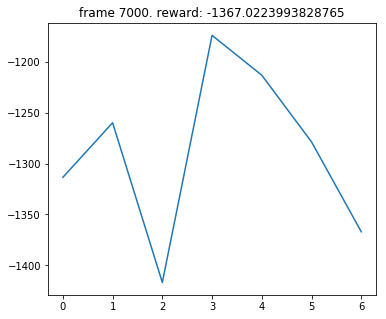

rewards:  -1367.0223993828765


In [ ]:
# k = PpoImport()

# k.func()